In [1]:
##combine PP and IO for NMF

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd

import sys

sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis/py_functions')

from scipy.stats import norm
from tkinter import *
import scipy
from scipy import signal

import platform
from glob import glob
from scipy.spatial import distance
import basic_func as bf
from scipy.integrate import simps
from numpy import trapz
import IO_func as IOF
import BM_func as BMf
import tqdm
from matplotlib.patches import Rectangle
from pathlib import Path
import LL_funcs as LLf
import freq_funcs as ff
#
from scipy.signal import hilbert, butter, filtfilt
import scipy.stats as stats
from tqdm.notebook import trange, tqdm
import significance_funcs as sig_func

dist_groups = np.array([[0, 30], [30, 60], [60, 120]])
dist_labels = ['local (<30 mm)', 'short (<60mm)', 'long']
Fs = 500
dur = np.zeros((1, 2), dtype=np.int32)
t0 = 1
dur[0, 0] = -t0
dur[0, 1] = 3

folder = 'BrainMapping'
# dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax = np.arange(dur[0, 0], dur[0, 1], (1 / Fs))
color_elab = np.zeros((3, 3))
color_elab[0, :] = np.array([31, 78, 121]) / 255
color_elab[1, :] = np.array([189, 215, 238]) / 255
color_elab[2, :] = np.array([0.256, 0.574, 0.431])
cwd = os.getcwd()
sub_path  ='X:\\4 e-Lab\\' # y:\\eLab

In [6]:
subj = 'EL011'
cond_folder = 'CR'  # Condition = 'Hour', 'Condition', 'Ph'

if cond_folder == 'Ph':
    cond_vals = np.arange(4)
    cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
    cond_colors = ['#494159', '#594157', "#F1BF98", "#8FB996"]
    cond1 = 'Condition'  # 'condition', 'h'
    cond_folder = 'Ph'  # 'Ph', 'Sleep', 'CR'
    Condition = 'Condition'
if cond_folder == 'CR':
    Condition = 'Hour'  # Condition = 'Hour'
    cond1 = 'h'  # h (as stored in stimlist)

######## General Infos

path_patient_analysis = sub_path+'\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
path_gen = os.path.join(sub_path+'\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
path_infos = os.path.join(path_patient, 'infos')
if not os.path.exists(path_infos):
    path_infos = path_gen + '\\infos'

sep = ';'
Fs = 500
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/BM_plot_trial').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/single_con').mkdir(parents=True,
                                                                                              exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/Pipeline').mkdir(parents=True, exist_ok=True)

# get labels
if cond_folder == 'Ph':
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*Ph*')
else:
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*')
i = 0
stimlist = pd.read_csv(files_list[i])
# EEG_resp = np.load(path_patient + '/Analysis/' + folder + '/data/ALL_resps_'+files_list[i][-11:-4]+'.npy')
lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
    stimlist,
    lbls)

labels_h = lbls.Hemisphere + '_' + labels_all

badchans = pd.read_csv(path_patient_analysis + '\\' + folder + '/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:, 1] == 1))[0, :])

bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]




In [10]:
file_con = path_patient_analysis + '\\InputOutput\\'+cond_folder+'/data/con_trial_all.csv'
con_trial_IO = pd.read_csv(file_con)
con_trial_IO.insert(4, 'Intp',0)
con_trial_IO.insert(4, 'IPI',0)

In [11]:
file_con = path_patient_analysis + '\\PairedPulse\\'+cond_folder+'/data/con_trial_all.csv'
con_trial_PP = pd.read_csv(file_con)
con_trial_PP.insert(4, 'Intp', con_trial_PP.Int)
con_trial_PP.loc[(con_trial_PP.Int==0), 'Int'] = 2

In [42]:
con_trial_PP.Num = con_trial_PP.Num+np.max(con_trial_IO.Num+1)

In [44]:
con_trial_exc = pd.concat([con_trial_IO,con_trial_PP])
con_trial_exc = con_trial_exc.reset_index(drop=True)
con_trial_exc = con_trial_exc.drop(columns=['P2P', 'nLL', 'Condition', 'LL_SP'])
con_trial_exc= con_trial_exc.reset_index(drop=True)

## NMF

In [46]:
con_trial_exc.loc[con_trial_exc.Sleep==0,'SleepState'] = 'Wake'
con_trial_exc.loc[con_trial_exc.Sleep==4,'SleepState'] = 'REM'
con_trial_exc.loc[(con_trial_exc.Sleep>1)&(con_trial_exc.Sleep<4),'SleepState'] = 'NREM'

In [63]:
nums_id = np.unique(con_trial_exc.Num).astype('int')

In [84]:
con_trial_exc_Stim = con_trial_exc[con_trial_exc.Stim==7]
con_trial_exc_Stim= con_trial_exc_Stim.reset_index(drop=True)

In [85]:
summ = con_trial_exc_Stim.groupby(['Chan', 'Num'])['LL'].mean()

In [86]:
V = summ.unstack(level='Num').values

In [88]:
V[np.isnan(V)] = np.mean(np.nanmean(V,1))
V[np.isnan(V)] = 1

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [75]:
import NMF_funcs as NMFf

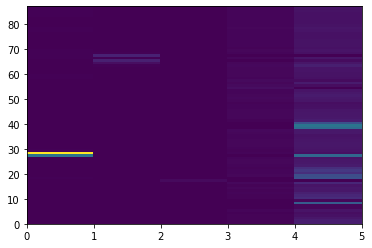

In [92]:
plt.pcolormesh(W)

In [112]:
col0 = ['Stim', 'Int', 'Intp','IPI','Block', 'Hour', 'Date', 'Sleep']  #  'Hour',
col = ['Stim', 'Int', 'Intp','IPI','Block', 'Hour', 'Date', 'Sleep']  #  'Hour',
W_col = []
H_col = []
for i in range(H.shape[0]):
    col.append('H' + str(i + 1))
    W_col.append('W' + str(i + 1))
    H_col.append('H' + str(i + 1))



In [113]:
con_nmf = np.zeros((H.shape[1], len(col0) + H.shape[0]))
con_nmf[:, len(col0):] = H.T


In [114]:
# add stim channel, Hour and Intensity
summ2 = con_trial_exc_Stim.groupby(['Num'], as_index=False)[col0].mean()
con_nmf[:, 0:len(col0)] = summ2.values[:, 1:]
con_nmf = pd.DataFrame(con_nmf, columns=col)

(0.0, 8.0)

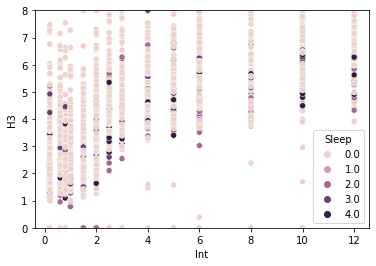

In [130]:
sns.scatterplot(x='Int', y= 'H3', hue='Sleep', data=con_nmf[(con_nmf.IPI==0)])
plt.ylim([0,8])

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 63.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 65.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 66.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 67.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings

(0.0, 8.0)

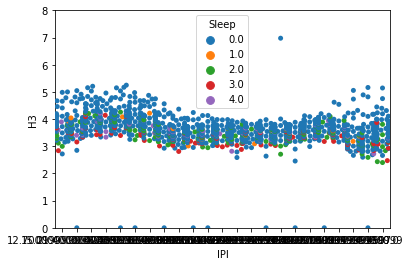

In [129]:
sns.swarmplot(x='IPI', y= 'H3', hue='Sleep', data=con_nmf[(con_nmf.Intp==4)])
plt.ylim([0,8])

In [89]:
[W, W0, H] = NMFf.get_nnmf_Epi(V, 5, it=4000)

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
